# **Modern NLP: Course project - Milestone 2**

#### **Team**: Alexander Sternfeld, Silvia Romanato and Antoine Bonnet (`syntax-sorcerers`)

## **Data Preparation**

This notebook aims to trains a prepare multiple datasets for the training of a reward model and the final finetuned chatbot. 

1. The [StackOverflow](https://www.kaggle.com/datasets/stackoverflow/stackoverflow) dataset will be used to train both models. It contains questions and answers from the StackOverflow forum, with the correct answer identified. 
2. The [EPFL Interactions]() dataset consists of human-rated interactions between a user and a chatbot of questions concerning EPFL course material. It will be used to train both models. 

We standardize all data sources into the same format with one entry per question-answer pair which are identified as correct or not. 


In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from stack_helpers import *
from classifier_model import *
from reward_dataset import *

%reload_ext autoreload
%autoreload 2


### 1. **StackOverflow dataset**

The StackOverflow dataset contains 27M+ answers on a wide variety of forums ranging multiple topics such as Computer Science, Mathematics and Physics. We are interested in comparing multiple answers for the same questions so as to compare them. 

We start out with 3 topics: Computer Science (`data/stack_cs`), Computer Science theory (`data/stack_cstheory`) and Data Science (`data/stack_ds`). 

The dataset is of the following form: each row corresponds to a given (question, answer) pair. 

- Each question has a title, body view count and ID (with topic identifier attached to it). 
  
- Each answer has a body, score (number of upvotes) and label (0 for non-accepted answer, 1 for accepted answer). 


In [29]:
# Import StackExchange data
stack_reward, _ = load_stack_data()

# Concatenate question title and body 
stack_reward['Question'] = stack_reward['Title'] + "" + stack_reward['Body']

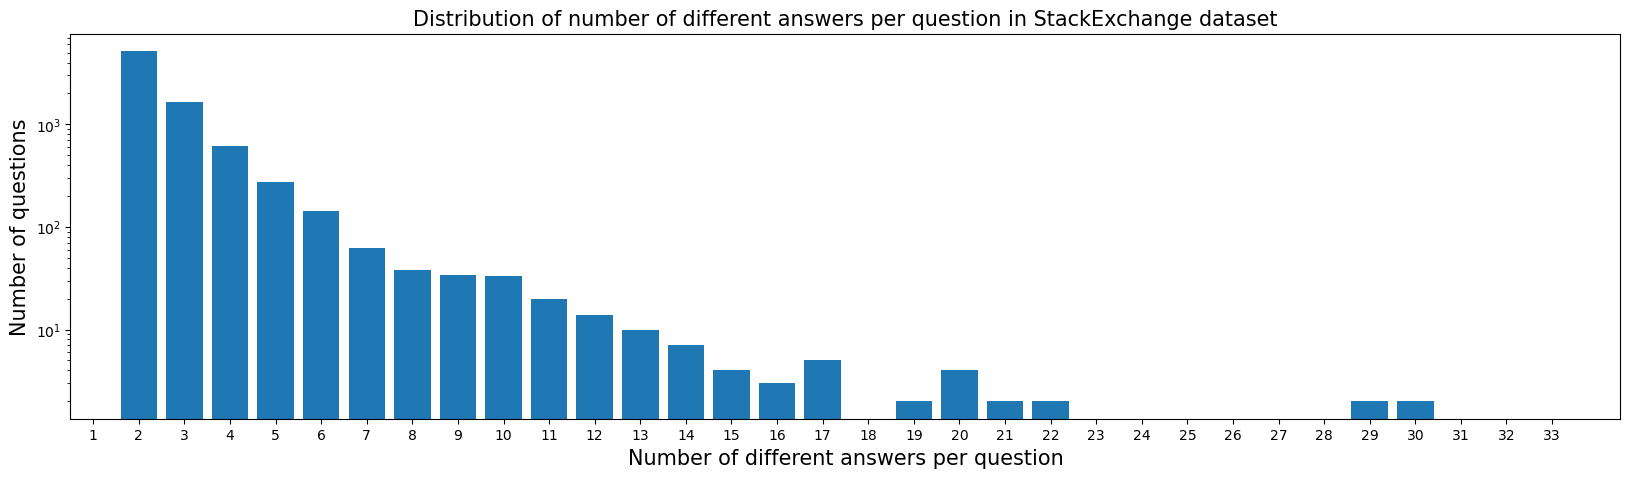

In [33]:
def plot_histogram(df): 
    # Plot the number of different answers per question in the dataset
    grouped_df = df.groupby("QuestionId").count()["Question"].values
    plt.figure(figsize=(20, 5))
    plt.hist(grouped_df, bins=range(2, 35), rwidth=0.8)
    plt.xlabel("Number of different answers per question", fontsize=15)
    plt.ylabel("Number of questions", fontsize=15)
    plt.title("Distribution of number of different answers per question in StackExchange dataset", fontsize=15)
    plt.xticks(np.arange(.5, 34.5, 1), np.arange(0, 34, 1))
    plt.xlim(1, 35)
    plt.yscale("log")
    plt.show()

plot_histogram(stack_reward)

We now do some pre-processing on this dataset to make it compatible with the RoBERTa model. We concatenate question and answers into a single string `Human: [Question] Assistant: [Answer]`. Each question-answer pair is assigned a label `1` if the answer is accepted by the poster, and `0` otherwise.

In [34]:
stack_reward = format_for_QA(stack_reward)

print("Total number of questions: ", len(stack_reward['QuestionId'].unique()))
print("Total number of answers: ", len(stack_reward[['QuestionId', 'AnswerId']].drop_duplicates()))

# Drop AnswerId column
stack_reward = stack_reward.drop(columns=['AnswerId'])

stack_reward.head()

Total number of questions:  8068
Total number of answers:  22441


,QuestionId,label,chat
0,0,1,Human: Can't use The SGD optimizer <p>I am usi...
1,0,0,Human: Can't use The SGD optimizer <p>I am usi...
2,1,1,"Human: Preprocessing , EDA , and Feature Engin..."
3,1,0,"Human: Preprocessing , EDA , and Feature Engin..."
4,2,0,Human: Examples of reversible computations <p>...


In [35]:
# Save the SE dataset as csv to feed the model
#stack_reward.to_csv(f"{DATA_DIR}/reward_model/stack_data.csv", index=False)

# We also save the dataset in the required format 
stack_reward['label'].replace({1: 'positive', 0: 'negative'}, inplace=True)
stack_reward['entry_id'] = stack_reward.index
stack_reward = stack_reward.drop(columns=['QuestionId'])

# Save dataset as json for clean submission
with open(f"{DATA_DIR}/reward_model/m2_reward_dataset_syntax-sorcerers_StackOverflow.json", 'w') as f:
    json.dump(stack_reward.to_dict(orient='records'), f, indent=4)

### **Ideas for improvement**

1. In the StackExchange data, we do not use the `AnswerScore` feature representing the number of upvotes. One idea would be to use this feature, as well as the `label` feature identifying an accepted answer to create a score that takes both the upvotes and the label into account. This would allow the use of a richer metric on answer quality.

### 2. **EPFL Interactions**

We now convert the ChatGPT interactions by EPFL students into a format compatible with the RoBERTa model. We concatenate question and answers into a single string `Human: [Question] Assistant: [Answer]`. This dataset consists of several EPFL course questions, each of which has an associated official solution as well as multiple interactions by EPFL students with ChatGPT that were rated on a confidence scale from 1 to 5. 

Our reward model requires contrastive learning; we train it to assign different rewards when comparing the official solution to incorrect solutions. Several problems now arise:

- Each student introduces bias when rating interactions, since they might not know the true answer to each question and they might have a different confidence scale. 
- We are not assured that the official solutions are the best answers to the questions when compared to the user interactions. ChatGPT might have provided a better answer than the official solution!

To solve these problems, we use the following assumptions:
- The official solution is the best answer to the question.
- Interactions rated between 1 and 2 by students are incorrect.
- Interactions rated 5 by students are correct. 

We therefore label the solution as well as interactions rated as 5 as correct, and all interactions with confidence 1 or 2 as incorrect. We then train our reward model to differentiate the correct for incorrect answers.

#### 2.1. **Problem solutions** 

We start by formatting the provided solutions. 

In [36]:
# Load the correct solutions
solutions = pd.read_json("../data/manual_chatgpt/solutions_v1.json")

solutions.head(3)

,answer,question,sol_id,choices,explanation,description,qtype
0,"Threshold flux for cones, $\phi_{r}=90 \times ...",Rods (peak response at $\lambda=507 \mathrm{~n...,1693719,NaN,NaN,NaN,NaN
1,faster movements,What are some advantages of using AODs vs scan...,2001870,"[faster movements, lower losses, more uniform ...",NaN,NaN,NaN
2,Black body releasing an arbitrarily high amoun...,What is the ultraviolet catastrophe?,1477066,[Black body releasing an arbitrarily high amou...,NaN,NaN,NaN


Taking a look at the official solutions, we see that we have 4450 solutions, and 1207 of them have an explanation. The fraction of them with a description or identified question type is marginal, so we throw these features away. We keep the explanations and append them to the solution if provided. 

In [37]:
# Print number of solutions with a description,and number of solutions with an explanation
print("Number of solutions with a description: ", len(solutions[solutions['description'].isna() == False]))
print("Number of solutions with an explanation: ", len(solutions[solutions['explanation'].isna() == False]))
print("Number of solutions with an identified question type: ", len(solutions[solutions['qtype'].isna() == False]))
print("Total number of solutions: ", len(solutions))


Number of solutions with a description:  22
Number of solutions with an explanation:  1207
Number of solutions with an identified question type:  120
Total number of solutions:  4450


We first concatenate the solutions into a `"Human: Question Assistant: Answer"` format. We then create a dataframe with the following columns: `questionId`, `answerId`, `chat` and `label` (1 for correct answer, 0 for incorrect answer).

In [38]:
def chat_from_solutions(question, answer, choices=None, explanation=None): 
    """ Create a chatbot interaction from a question, answer, and optionally choices and explanation. """
    print(question, answer, choices, explanation)
    chat = ""
    chat += f"Human: {question}\n\n"
    if choices is not None: 
        chat += f"\nSelect one of the following options:"
        chat += " ".join([f"{i+1}. {choice}\n" for i, choice in enumerate(choices)])
    chat += f"Assistant: {answer}\n\n"
    if explanation is not None:
        chat += f"\n{explanation}"
    return chat

solutions['chat'] = solutions.replace({np.nan: None})[['question', 'answer', 'choices', 'explanation']].apply(
    lambda x: chat_from_solutions(x['question'], x['answer'], x['choices'], x['explanation']), axis=1)

# Only keep columns sol_id, chat
solutions = solutions[['sol_id', 'chat']] 

solutions.head()

,sol_id,chat
0,1693719,Human: Rods (peak response at $\lambda=507 \ma...
1,2001870,Human: What are some advantages of using AODs ...
2,1477066,Human: What is the ultraviolet catastrophe?\n\...
3,2578719,Human: Which light should be used to activate ...
4,1095453,Human: In a sample with an absorbance of 1 (A=...


#### 2.2. **User interactions**

We now pre-process the student interactions in a similar fashion. The interactions are of the form 

`{"role": "system", "content": Instruction},
{"role": "user", "content": Question},
{"role": "assistant", "content": Answer}, ...`

Note that we remove user instructions, since otherwise the model would learn to identify the user instructions as incorrect answers and because they do not follow the same format as regular question-answer pairs. 


In [39]:
# Load the EPFL student interactions
interactions = pd.read_json("../data/manual_chatgpt/interactions_v1.json")

# Filter out NaN interactions
interactions = interactions[interactions['interaction'].isna() == False]

interactions.head(3)

,confidence,interaction,sol_id,interaction_id,choices,question,display_name,name,created_at,model_type,instruction_prefix,user_prefix,assistant_prefix,is_open,prediction,prompt,instruction
0,4,"[{'role': 'system', 'content': 'Give a best ap...",1693719,4399371,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,"[{'role': 'system', 'content': 'The context is...",2001870,4768577,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,"[{'role': 'system', 'content': 'Explain in one...",1477066,4510626,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Convert the interactions into a single chat string
def chat_from_interactions(interactions): 
    """ Create a chatbot interaction from an interaction. """
    chat = ''
    for interaction in interactions:
        role = interaction['role']
        content = interaction['content']
        #if role == 'system':                       # We do not add the prompting strategy!
        #    chat += f"System: {content}\n\n"
        if role == 'user': 
            chat += f"Human: {content}\n\n"
        elif role == 'assistant': 
            chat += f"Assistant: {content}\n\n"
    return chat

interactions['chat'] = interactions[['interaction']].apply(lambda x: chat_from_interactions(x['interaction']), axis=1)

# Only keep columns sol_id, interaction_id, chat, confidence
interactions = interactions[['sol_id', 'interaction_id', 'chat', 'confidence']]
interactions.head()

,sol_id,interaction_id,chat,confidence
0,1693719,4399371,Human: What are the peak response values of th...,4
1,2001870,4768577,Human: What are some possible full forms of AO...,5
2,1477066,4510626,Human: What is the ultraviolet catastrophe?\n\...,5
3,2578719,4085955,Human: Which light should be used to activate ...,5
4,1095453,4146802,Human: What do mean by absorbance?\n\nAssistan...,5


We notice that some EPFL students used wrong confidence values (outside the 1-5 range). We remove these interactions from the dataset.


In [41]:
interactions['confidence'].value_counts().rename_axis('confidence').reset_index(name='counts').sort_values(by=['confidence'])


,confidence,counts
6,-4,2
7,-1,1
5,0,126
4,1,587
3,2,881
2,3,1789
1,4,2907
0,5,4540
8,6,1
9,45,1


Another problem is that some user interactions are few-shot, meaning that multiple prompts were used to generate the answer. This is never the case for solutions, which are all one-shot. The model might learn to recognize chats with multiple `Human:` and `Assistant:` prompts as incorrect answers. We have two choices now: 

- **Option 1**: Remove all interactions with multiple prompts. 

- **Option 2**: Add some interactions with confidence 5 into the correct answers mix. 

Let's look at the distribution of the number of prompts in the user interactions to guide our choice. 

3192 out of 7797 interactions are few-shot.


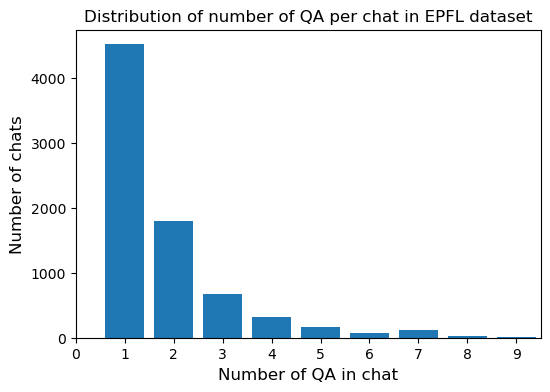

In [42]:
# Only keep innteractions with valid confidence, remove confidence 3 or 4
interactions = interactions[interactions['confidence'].isin([1,2,3,5])]

few_shot = len(interactions['chat'].str.count("Human:")[(interactions['chat'].str.count("Human:") >= 2)])
print(f'{few_shot} out of {len(interactions)} interactions are few-shot.')

# Count the number of "Human:" substring in each chat, plot histogram
interactions['chat'].str.count("Human:").hist(bins=range(1, 20), rwidth=0.8, figsize=(6, 4))
plt.xlabel("Number of QA in chat", fontsize=12)
plt.ylabel("Number of chats", fontsize=12)
plt.title("Distribution of number of QA per chat in EPFL dataset", fontsize=12)
plt.xticks(np.arange(.5, 19.5, 1), np.arange(0, 19, 1))
plt.xlim(0.5, 10)
plt.grid(False)
plt.show()

Removing all few-shot interactions would remove about 40% of the dataset. We therefore choose to keep them, and add all interactions with confidence 5 to the correct answers mix.

We then join the solutions and user interactions into a single dataset. We label interactions with confidence 1, 2 or 3 as incorrect answers, and the official solutions as well as interactions with confidence 5 as correct answers. We keep only questions for which we have at least one correct answer and one incorrect answer.

In [43]:
# Format solutions before merge
solutions = solutions.rename(columns={'sol_id': 'QuestionId'})
solutions['label'] = 1

# Format interactions before merge 
interactions = interactions.rename(columns={'sol_id': 'QuestionId'})
interactions = interactions.drop(columns=['interaction_id'])
interactions['label'] = interactions['confidence'].apply(lambda x: 1 if x == 5 else 0) # Label = 1 if confidence = 5, else 0

# Combine into a single dataframe
EPFL_data = pd.concat([solutions, interactions]).sort_values(by=['QuestionId'])
print('Before filtering out questions with only 0 or only 1 labels: ', len(EPFL_data))

# Remove all questions for which we don't have at least one 0 label and one 1 label
EPFL_data = EPFL_data.groupby('QuestionId').filter(lambda x: len(x[x['label'] == 0]) > 0 and len(x[x['label'] == 1]) > 0)
print('After filtering out questions with only 0 or only 1 labels: ', len(EPFL_data))

# Sort by questionId, reset index, remove confidence column
EPFL_data = EPFL_data.sort_values(by=['QuestionId'])
EPFL_data = EPFL_data.reset_index(drop=True).drop(columns=['confidence'])
EPFL_data.head(10)

Before filtering out questions with only 0 or only 1 labels:  12247
After filtering out questions with only 0 or only 1 labels:  6955


,QuestionId,chat,label
0,1000851,Human: Une conquille sphérique de rayon $R_1$ ...,0
1,1000851,Human: Une conquille sphérique de rayon $R_1$ ...,0
2,1000851,Human: Une conquille sphérique de rayon $R_1$ ...,1
3,1001417,Human: Assume that we have a convolutional neu...,1
4,1001417,Human: Q: Which of the following functions rea...,0
5,1003280,Human: From the steady solution of this differ...,1
6,1003280,Human: From the steady solution of this differ...,0
7,1003546,Human: Pense étape par étape: D{\'e}terminez l...,1
8,1003546,Human: D{é}terminez les lignes de courant $y =...,1
9,1003546,Human: D{\'e}terminez les lignes de courant $y...,1


In [44]:
# Save the EPFL dataset as csv to feed the model
#EPFL_data.to_csv(f"{DATA_DIR}/reward_model/EPFL_data.csv", index=False)

# We also save the dataset in the required format
EPFL_data['label'].replace({1: 'positive', 0: 'negative'}, inplace=True)
EPFL_data['entry_id'] = EPFL_data.index
EPFL_data = EPFL_data.drop(columns=['QuestionId'])

# Save dataset as json for clean submission
with open(f"{DATA_DIR}/reward_model/m2_reward_dataset_syntax-sorcerers_EPFL.json", 'w') as f:
    json.dump(EPFL_data.to_dict(orient='records'), f, indent=4)

EPFL_data.head()


,chat,label,entry_id
0,Human: Une conquille sphérique de rayon $R_1$ ...,negative,0
1,Human: Une conquille sphérique de rayon $R_1$ ...,negative,1
2,Human: Une conquille sphérique de rayon $R_1$ ...,positive,2
3,Human: Assume that we have a convolutional neu...,positive,3
4,Human: Q: Which of the following functions rea...,negative,4


In [ ]:
EPFL_data = pd.read_json(f"{DATA_DIR}/reward_model/m2_reward_dataset_syntax-sorcerers_EPFL.json")